In [1]:
#import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import seaborn as sns

# 目录

- [1. 项目背景](#section1)  
- [2. 数据概览](#section2) 
- [3. 数据处理](#section3)
- [4. 数据分析 & 可视化](#section4)
  - [季度分析](#section6)
  - [月度分析](#section7)
  - [节假日分析](#section8)
- [5. 结论与建议](#section5) 

<a id="section1"></a>

# 1. 项目背景

本项目选用一份阿里云天池平台公开的电商顾客交易数据，旨在通过时间序列分析与RFM 客户价值模型两种方式，以GMV为主要指标，挖掘整体销售规律与用户价值分布，进而可为运营和营销策略提供决策依据。

项目主要包含两种分析：

- 时间序列分析：


  通过时间维度销售趋势分析，识别日/月/季度的销售高峰与低谷，特别关注“双 11”、“618”等关键促销节点的效果,


  了解各品类（如服装、鞋履、图书等）在不同季度的表现差异，为库存及广告投放决策提供依据。

- RFM:

  由于数据集仅记录了每位用户的一次交易，传统的“Frequency”指标均为 1，因此本次 RFM 分析仅对 Recency（最近购买距离） 与 Monetary（累计消费金额） 进行打分。

  结合顾客的性别、年龄分段，基于 R_Score 与 M_Score 构建客户分群，以区分“高价值客户”、“中价值客户”、“低价值客户”及其他潜在分层，从而为精准营销与会员体系运营提供参考。



<a id="section2"></a>

# 2. 数据概览

本次数据共含有99457张订单

In [2]:
data = pd.read_csv('D:/MachineLearning/datasets/tian_chi/customer_shopping_data.csv')
data.shape

(99457, 9)

订单涵盖 2021-01-01 至 2023-03-08

In [3]:
data['invoice_date'].min(), data['invoice_date'].max()

('1/1/2021', '9/9/2022')

| 字段名         | 含义                                                                 |
| -------------- | -------------------------------------------------------------------- |
| invoice_no     | 发票号码（唯一识别一次交易）                                           |
| customer_id    | 顾客 ID（用于区分不同用户）                                           |
| gender         | 性别（“Male”/“Female”）                                              |
| age            | 年龄（整数）                                                          |
| category       | 商品品类（“Clothing”、“Shoes”、“Books”等）                        |
| quantity       | 购买数量                                                              |
| price          | 金额（本例中为单次购买的总价）                                         |
| payment_method | 支付方式（“Alipay”、“WeChat Pay”、“Card”）                       |
| invoice_date   | 交易日期（格式：YYYY-MM-DD，例如“2021-11-09”）                       |

In [4]:
data.head()

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date
0,I138884,C241288,Female,28,Clothing,5,1500.40,Alipay,5/8/2022
1,I317333,C111565,Male,21,Shoes,3,1800.51,WeChat Pay,12/12/2021
2,I127801,C266599,Male,20,Clothing,1,300.08,Card,9/11/2021
3,I173702,C988172,Female,66,Shoes,5,3000.85,Alipay,16/05/2021
4,I337046,C189076,Female,53,Books,4,60.60,Card,24/10/2021


值得注意的是，数据集中每一位顾客均只有一次订单，并且同一品类中不同订单的平均单件商品价格相同

In [5]:
data.groupby('customer_id').agg({
    'invoice_no': 'nunique'
}).value_counts()

invoice_no
1             99457
Name: count, dtype: int64

In [6]:
data['aqv'] = (data['price'] / data['quantity']).round(2)
data.groupby('category').agg({
    'aqv': 'nunique'
})

,aqv
category,
Books,1
Clothing,1
Cosmetics,1
Food & Beverage,1
Shoes,1
Souvenir,1
Technology,1
Toys,1


<a id="section3"></a>

# 3. 数据处理

数据集不含NA值

In [7]:
data.isna().sum()

invoice_no        0
customer_id       0
gender            0
age               0
category          0
quantity          0
price             0
payment_method    0
invoice_date      0
aqv               0
dtype: int64

我们将顾客的年龄转换为categorical variable,也就是将他们的年龄划为5组，五个年龄组对应的年龄段分别为：(18, 28]，(28, 38]， (38, 49]，(49, 59]以及(59, 69]，同时创建日/月/季度列便于后续分析

In [8]:
data["age_cat"] = pd.qcut(
    data["age"],
    q = 5,
    labels = [1,2,3,4,5]
)
data['invoice_date'] = pd.to_datetime(data['invoice_date'], dayfirst=True)
data['quarter'] = data['invoice_date'].dt.to_period('Q').astype(str)
data['month'] = data['invoice_date'].dt.to_period('M').astype(str)
data['day'] = data['invoice_date'].dt.to_period('D').astype(str)

<a id="section4"></a>

# 4. 数据分析 & 可视化

## 整体情况分析

我们首先探寻此平台的顾客总体情况

### 顾客性别

In [9]:
gender_value = [sum(data["gender"] == 'Female'), sum(data["gender"] == 'Male')]
gender = ['Female', 'Male']

In [10]:
print('女性占比:', round(gender_value[0] * 100/ sum(gender_value),2),'%',
     '\n男性占比:', round(gender_value[1] * 100/ sum(gender_value),2),'%')

女性占比: 59.81 % 
男性占比: 40.19 %


此平台女性顾客下单数与总消费金额相较男性均多约10%，为平台重点客户群体

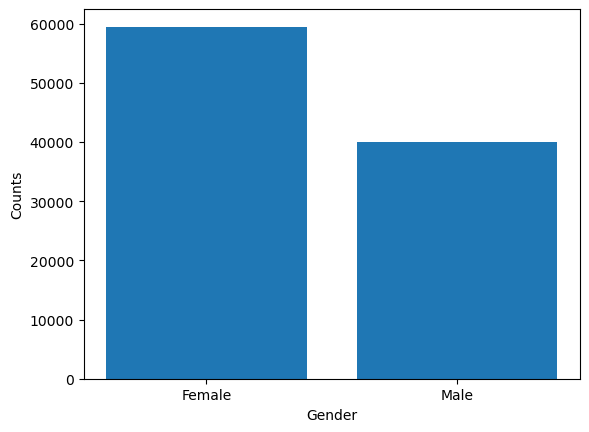

In [11]:
plt.figure()
plt.bar(gender, gender_value)
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.show()

In [12]:
data.groupby('gender')['price'].sum() / sum(data['price'])

gender
Female    0.597097
Male      0.402903
Name: price, dtype: float64

### 顾客年龄

平台顾客最大年龄到69岁，最小到18岁

In [13]:
data['age'].describe()

count    99457.000000
mean        43.427089
std         14.990054
min         18.000000
25%         30.000000
50%         43.000000
75%         56.000000
max         69.000000
Name: age, dtype: float64

顾客整体呈均匀分布, 第一与第三年龄组（18 ~ 28，39 ~ 49）的顾客在单数以及消费总金额上贡献均相对其他年龄组更多

In [14]:
age_value = [sum(data["age_cat"] == 1), sum(data["age_cat"] == 2),sum(data["age_cat"] == 3),
             sum(data["age_cat"] == 4), sum(data["age_cat"] == 5)]
age = sorted(data["age_cat"].values.unique().astype(int))

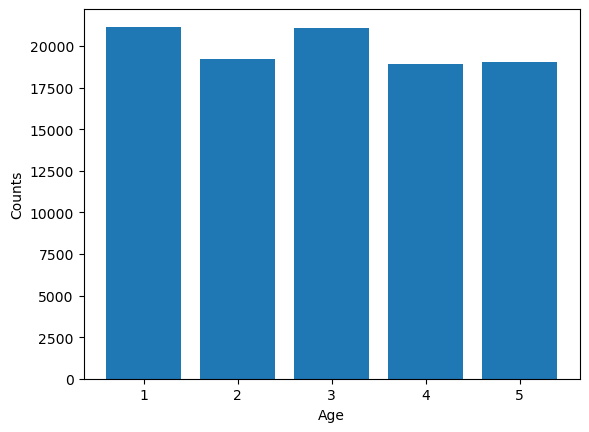

In [15]:
plt.figure()
plt.bar(age, age_value)
plt.xlabel('Age')
plt.ylabel('Counts')
plt.show()

In [16]:
data.groupby('age_cat')['price'].sum() / sum(data['price'])

age_cat
1    0.211588
2    0.192440
3    0.215269
4    0.188720
5    0.191983
Name: price, dtype: float64

再探寻商品品类情况

### 商品品类

衣物品类订单远超于其他品类，化妆品与食物饮料位列第二，其次是玩具与鞋，最后是纪念品、科技产品和书

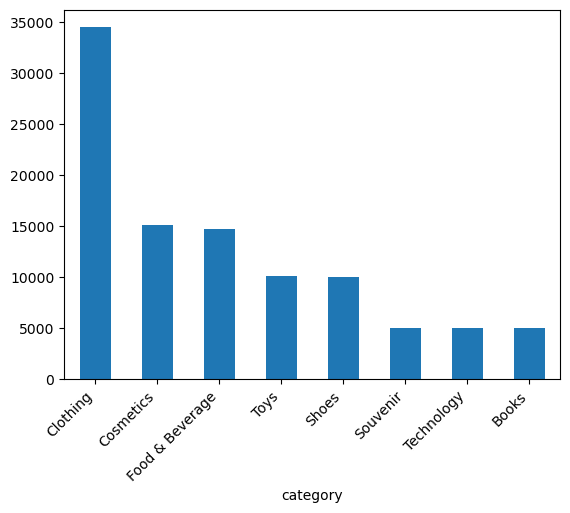

In [17]:
plt.figure()
data['category'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=45, ha='right')
plt.show()

从品类总销售额看，衣物品类贡献最大，是平台核心，其次是鞋与科技产品；化妆品与食物饮料虽订单量大，但总GMV占比非常小，因此我们在后续分析统一把含化妆品与食物饮料的其余所有品类归为 ‘others’

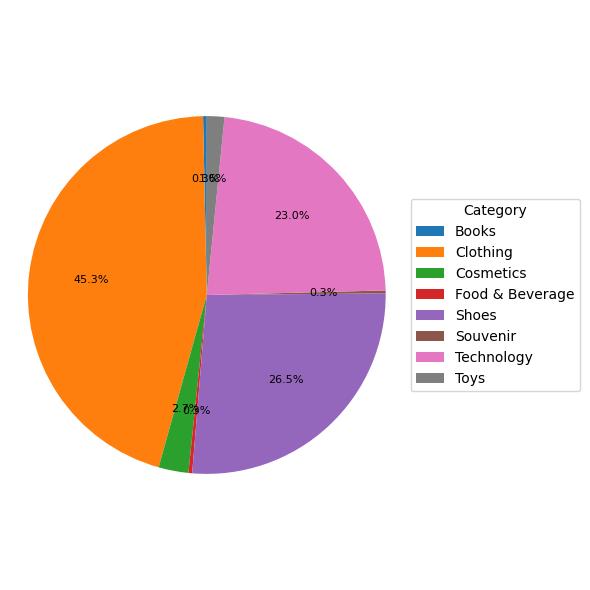

In [18]:
pct = data.groupby('category')['price'].sum() / sum(data['price'])
pct = pct.reset_index(name='pct')
pct = pct.set_index('category')

fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    pct['pct'],
    labels = None,
    autopct = '%1.1f%%',
    startangle=90,
    pctdistance=0.65,
    textprops={'fontsize': 8}
)
ax.legend(
    wedges,
    pct.index,
    title="Category",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

ax.axis('equal')
plt.tight_layout()
plt.show()

In [19]:
others = ['Food & Beverage', 'Souvenir', 'Toys', 'Cosmetics', 'Books']
data.loc[data['category'].isin(others), 'category'] = 'Others'
np.unique(data['category'])

array(['Clothing', 'Others', 'Shoes', 'Technology'], dtype=object)

最后探寻支付方式情况

### 支付方式

用银行卡支付的用户最多，微信支付的用户最少，且用银行卡支付的订单总金额与平均单笔金额均最高，用微信支付的最少

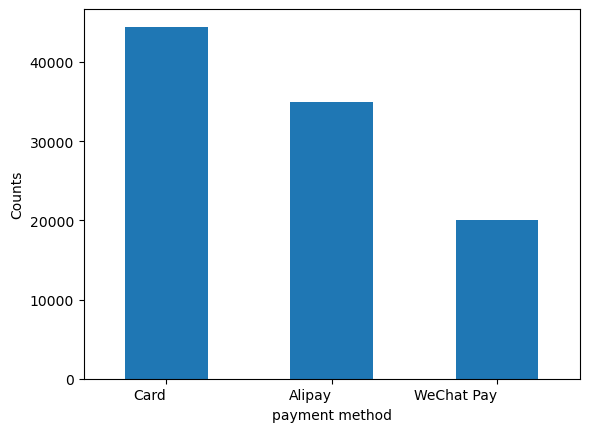

In [20]:
plt.figure()
data['payment_method'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=0, ha='right')
plt.xlabel('payment method')
plt.ylabel('Counts')
plt.show()

In [21]:
print('GMV proportion:')
print(data.groupby('payment_method')['price'].sum() / sum(data['price']))

GMV proportion:
payment_method
Alipay        0.350853
Card          0.447913
WeChat Pay    0.201234
Name: price, dtype: float64


In [22]:
data.groupby('payment_method').agg({
    'price': 'mean'
}).rename(columns = {'price': 'average price'})

,average price
payment_method,
Alipay,688.542467
Card,690.823475
WeChat Pay,687.029135


## 时间维度分析

我们首先将时间拆解为季度进行分析，探寻其中可能的规律以及潜在的问题

<a id="section6"></a>

### 季度分析

从季度上看GMV，每年年初第一季度到第三季度持续攀登，第三季度到第四季度稍下降；

每年第一季度是低谷；第二，三与四季度是增长关键季度，第四季度相较前两季度稍乏力

In [23]:
quar = data.groupby('quarter').agg({
    'price': 'sum'
})
quar = quar.iloc[:-1]

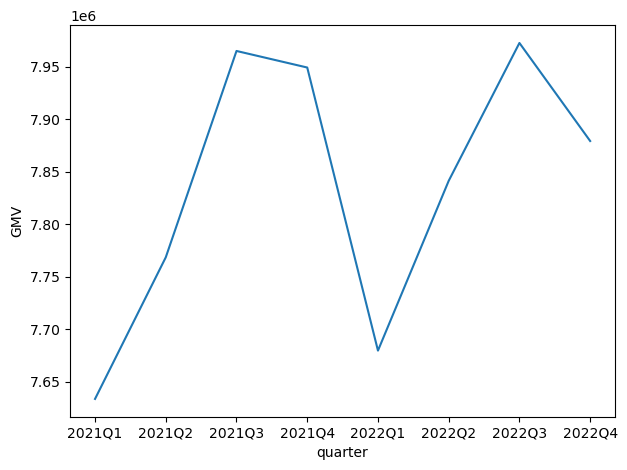

In [24]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(quar.index, quar.values)
plt.xlabel('quarter')
plt.ylabel('GMV')
plt.tight_layout()
plt.show()

同时我们再从季度GMV的环比与同比分析

In [25]:
price_series = quar['price'].copy()
price_series.index = pd.PeriodIndex(price_series.index, freq="Q")
qoq_pct_quar = price_series.pct_change(periods=1) * 100
yoy_pct_quar = price_series.pct_change(periods=4) * 100

In [26]:
df_q = pd.DataFrame({
    "price":   price_series,
    "qoq_pct": qoq_pct_quar,
    "yoy_pct": yoy_pct_quar
})

df_q['quarter'] = df_q.index.astype(str)

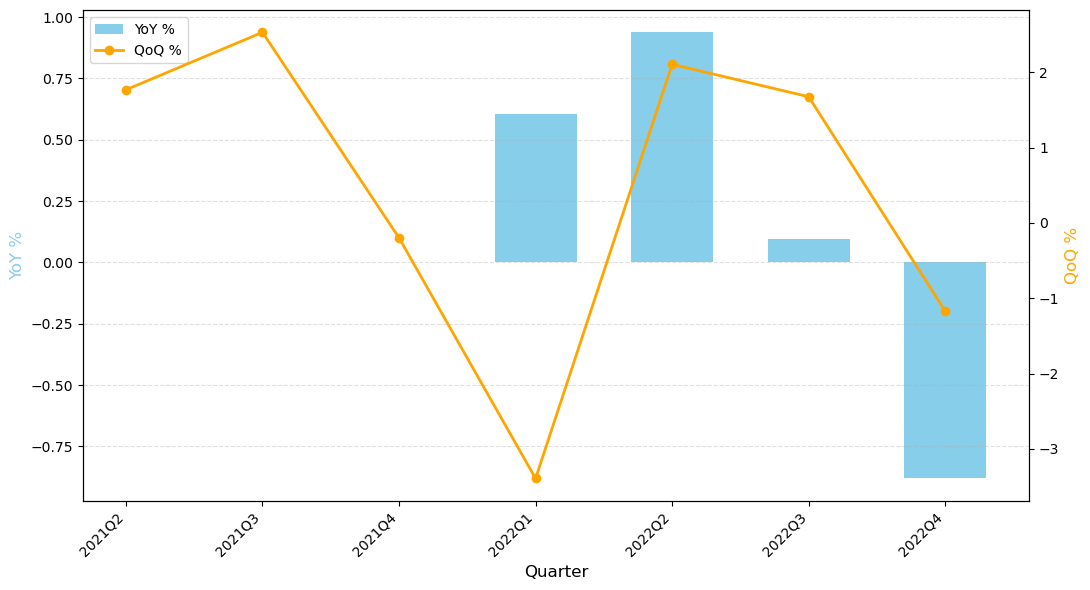

In [27]:
fig, ax = plt.subplots(figsize=(11, 6))

bar_width = 0.6
ax.bar(
    df_q["quarter"],
    df_q["yoy_pct"],
    width=bar_width,
    color="skyblue",
    label="YoY %"
)

ax2 = ax.twinx()
ax2.plot(
    df_q["quarter"],
    df_q["qoq_pct"],
    color="orange",
    marker="o",
    linewidth=2,
    label="QoQ %"
)

ax.set_xlabel("Quarter", fontsize=12)
ax.set_ylabel("YoY %", fontsize=12, color="skyblue")
ax2.set_ylabel("QoQ %", fontsize=12, color="orange")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

2022年除 Q4 季度外所有季度同比均有上涨，且22年 Q4 环比相较21 Q4 环比下跌更多，22年Q4业务出现一定问题

<a id="section7"></a>

### 月度分析

In [28]:
mon = data.groupby('month').agg({
    'price': 'sum'
})
mon = mon.iloc[:-1]

从月度上看GMV，第一季度中2月规律性乏力，后第三月回暖；

每年7月与10月为全年顶峰两月，2月为全年低谷；

5月为第二季度关键月，同样的第三季度为第7月，第四季度为第10月

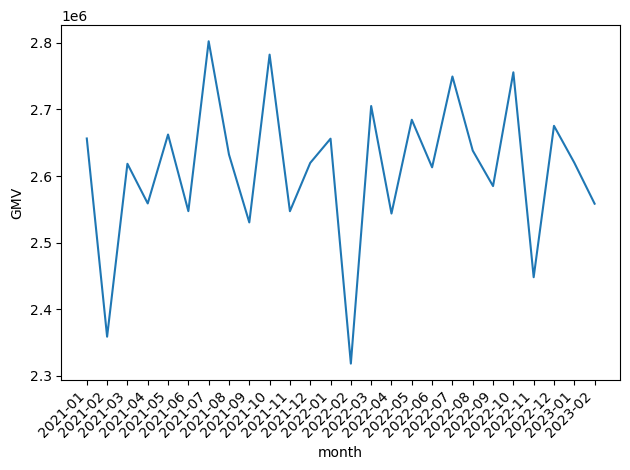

In [29]:
plt.figure()
plt.plot(mon.index, mon.values)
plt.xlabel('month')
plt.ylabel('GMV')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

同样地，我们再从月度GMV的环比与同比进行分析

In [30]:
price_series = mon['price'].copy()
price_series.index = pd.to_datetime(price_series.index, format="%Y-%m")

mom_pct = price_series.pct_change(periods=1) * 100
yoy_pct = price_series.pct_change(periods=12) * 100

df_m = pd.DataFrame({
    "price":   price_series,
    "mom_pct": mom_pct,
    "yoy_pct": yoy_pct
})

df_m['month_str'] = df_m.index.strftime("%Y-%m")

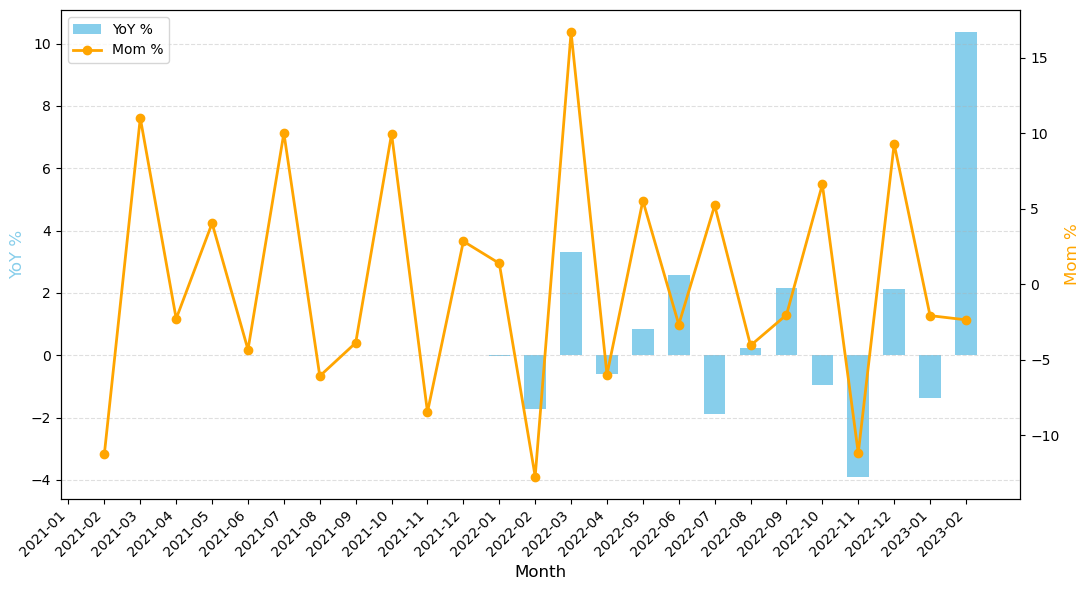

In [31]:
fig, ax = plt.subplots(figsize=(11, 6))

bar_width = 0.6
ax.bar(
    df_m["month_str"],
    df_m["yoy_pct"],
    width=bar_width,
    color="skyblue",
    label="YoY %"
)

ax2 = ax.twinx()
ax2.plot(
    df_m["month_str"],
    df_m["mom_pct"],
    color="orange",
    marker="o",
    linewidth=2,
    label="Mom %"
)

ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("YoY %", fontsize=12, color="skyblue")
ax2.set_ylabel("Mom %", fontsize=12, color="orange")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left")

ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

22年Q4同比差主要因为10月与11月同比差

从环比看符合从月度GMV观察到的规律（第一季度中2月规律性乏力，后3月回暖；5月为第二季度关键月，同样的第三季度为7月，第四季度为10月）

从同比看22年2，7，10与11月乏力明显，3，6，9与12月表现相对较好，其中三月环比与同比均可观

而23年2月虽然仍规律性环比下跌，但同比异常高

在从时间维度观察到潜在的规律以及表现较好与较差的时间段后，我们从品类维度出发，探寻是否有品类维度上某品类的变化导致规律的出现或某时间段GMV表现差

In [32]:
quar_c = data[data['category'] == 'Clothing'].groupby('quarter').agg({
    'price': 'sum'
})
quar_c = quar_c.iloc[:-1]

quar_o = data[data['category'] == 'Others'].groupby('quarter').agg({
    'price': 'sum'
})
quar_o = quar_o.iloc[:-1]

quar_s = data[data['category'] == 'Shoes'].groupby('quarter').agg({
    'price': 'sum'
})
quar_s = quar_s.iloc[:-1]

quar_t = data[data['category'] == 'Technology'].groupby('quarter').agg({
    'price': 'sum'
})
quar_t = quar_t.iloc[:-1]

<Figure size 1000x500 with 0 Axes>

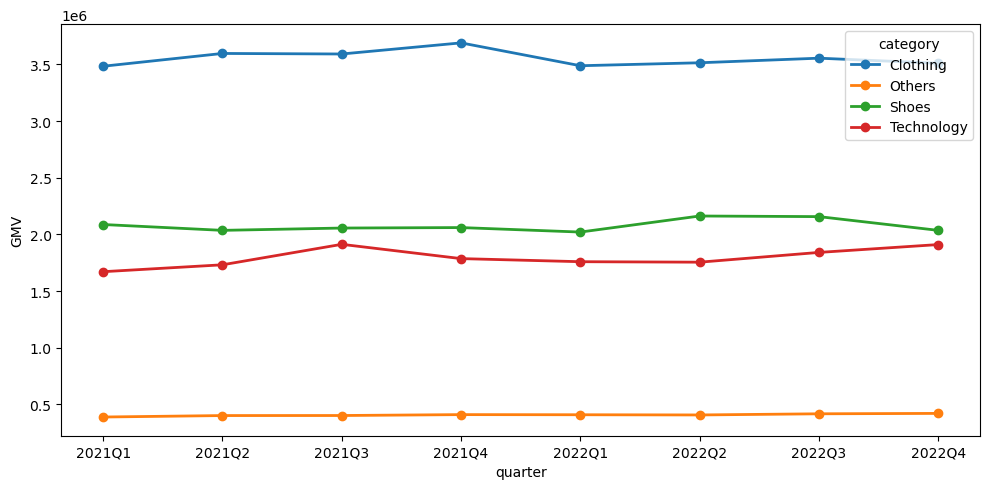

In [33]:
df = pd.DataFrame({
    'Clothing':   quar_c['price'],
    'Others':     quar_o['price'],
    'Shoes':      quar_s['price'],
    'Technology': quar_t['price']
})

plt.figure(figsize=(10, 5))

ax = df.plot(
    kind='line',
    marker='o',       
    figsize=(10,5),
    linewidth=2       
)

ax.set_xticks(range(len(df.index)))

ax.set_xlabel('quarter', fontsize=10)
ax.set_ylabel('GMV', fontsize=10)
ax.legend(title='category')    

plt.tight_layout()
plt.show()

从每季度各品类的表现上看，22年第一季度低谷是因为衣物品类GMV相较上一年年末有一定下跌

年初第一季度到第三季度衣物品类GMV持续上涨，其他两关键品类保持稳定或小幅上涨使年初第一季度到第三季度持续攀登

我们再探寻每月各品类的表现

In [34]:
mon_c = data[data['category'] == 'Clothing'].groupby('month').agg({
    'price': 'sum'
})
mon_c = mon_c.iloc[:-1]

mon_o = data[data['category'] == 'Others'].groupby('month').agg({
    'price': 'sum'
})
mon_o = mon_o.iloc[:-1]

mon_s = data[data['category'] == 'Shoes'].groupby('month').agg({
    'price': 'sum'
})
mon_s = mon_s.iloc[:-1]

mon_t = data[data['category'] == 'Technology'].groupby('month').agg({
    'price': 'sum'
})
mon_t = mon_t.iloc[:-1]

df = pd.DataFrame({
    'Clothing':   mon_c['price'],
    'Others':     mon_o['price'],
    'Shoes':      mon_s['price'],
    'Technology': mon_t['price']
})

<Figure size 1000x500 with 0 Axes>

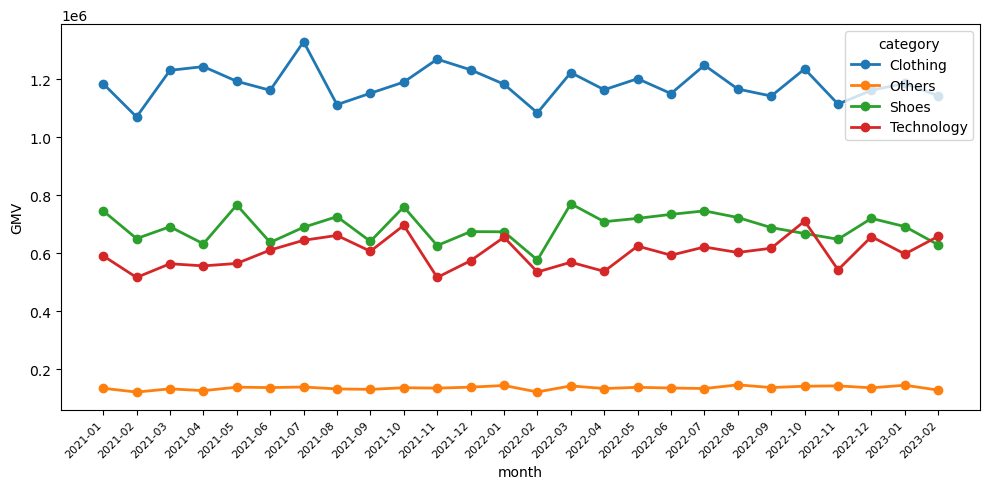

In [35]:
plt.figure(figsize=(10, 5))

ax = df.plot(
    kind='line',
    marker='o',      
    figsize=(10,5),
    linewidth=2      
)

ax.set_xticks(range(len(df.index)))
ax.set_xticklabels(df.index, rotation=45, ha='right', fontsize=8)

ax.set_xlabel('month', fontsize=10)
ax.set_ylabel('GMV', fontsize=10)
ax.legend(title='category')  

plt.tight_layout()
plt.show()

衣物: 每年1月-3月降增规律， 7月固定顶峰，2月固定低谷

鞋: 每年1月-3月降增规律, 4月至7月为增长期；顶峰随年变化，

科技产品：每年1月-3月降增规律,10-12月降增；10月稳定顶峰，接着11月低谷

每一季度关键月均与三大主力品类 -- 衣物、鞋和科技产品 -- 上涨有关，而每年第一季度2月低谷，3月回暖也是与三大主力品类相联系

其中22年2月同比差主要因为鞋类同比下跌严重，尽管衣物与科技产品品类均同比上涨，仍无法弥补；同样地，7月衣物与科技产品同比下滑严重，10月鞋品类严重，11月衣物品类严重

而3，6与9月鞋品类发力明显，带动当月整体增长，12月鞋类与科技产品品类共同发力带动增长，其中科技产品表现更加突出

23年2月同比突出类似22年12月，科技产品发力明显

并且从品类维度看22年Q4表现差的原因是10月与11月经历鞋类与衣物的同比严重下跌

In [36]:
price_series_c = mon_c['price'].copy()
price_series_c.index = pd.to_datetime(price_series_c.index, format="%Y-%m")

mom_pct_c = price_series_c.pct_change(periods=1) * 100
yoy_pct_C = price_series_c.pct_change(periods=12) * 100

df_c = pd.DataFrame({
    "price":   price_series_c,
    "mom_pct": mom_pct_c,
    "yoy_pct": yoy_pct_C
})

df_c['month_str'] = df_c.index.strftime("%Y-%m")

price_series_s = mon_s['price'].copy()
price_series_s.index = pd.to_datetime(price_series_s.index, format="%Y-%m")

mom_pct_s = price_series_s.pct_change(periods=1) * 100
yoy_pct_s = price_series_s.pct_change(periods=12) * 100

df_s = pd.DataFrame({
    "price":   price_series_s,
    "mom_pct": mom_pct_s,
    "yoy_pct": yoy_pct_s
})

df_s['month_str'] = df_s.index.strftime("%Y-%m")

price_series_t = mon_t['price'].copy()
price_series_t.index = pd.to_datetime(price_series_t.index, format="%Y-%m")

mom_pct_t = price_series_t.pct_change(periods=1) * 100
yoy_pct_t = price_series_t.pct_change(periods=12) * 100

df_t = pd.DataFrame({
    "price":   price_series_t,
    "mom_pct": mom_pct_t,
    "yoy_pct": yoy_pct_t
})

df_t['month_str'] = df_t.index.strftime("%Y-%m")


df_cat_yoy = pd.concat(
    [df_c['yoy_pct'], df_s['yoy_pct'], df_t['yoy_pct']],
    axis=1,
    keys=['Clothing','Shoes','Technology']
)
df_cat_yoy = df_cat_yoy[df_cat_yoy['Shoes'].notna().values]

In [37]:
print(f"{'Month':<12} {'Clothing YoY':>9}  {'Shoes YoY':>9}  {'Technology YoY':>8}")
for m in df_cat_yoy.index:
    print(
        f"{m.strftime('%Y-%m'):<12}", 
        f"{df_cat_yoy.loc[m,'Clothing']:>8.2f}%",
        f"{df_cat_yoy.loc[m,'Shoes']:>8.2f}%",
        f"{df_cat_yoy.loc[m,'Technology']:>8.2f}%"
    )

Month        Clothing YoY  Shoes YoY  Technology YoY
2022-01         -0.15%    -9.65%    10.83%
2022-02          1.32%   -11.35%     3.66%
2022-03         -0.63%    11.46%     0.93%
2022-04         -6.42%    12.05%    -3.40%
2022-05          0.75%    -6.03%    10.59%
2022-06         -0.98%    15.16%    -2.92%
2022-07         -6.10%     8.18%    -3.58%
2022-08          4.83%    -0.41%    -8.89%
2022-09         -0.83%     7.40%     1.73%
2022-10          3.81%   -12.09%     2.11%
2022-11        -12.20%     3.45%     5.08%
2022-12         -5.72%     6.76%    14.44%
2023-01          0.23%     2.67%    -8.81%
2023-02          5.43%     9.05%    22.94%


在探寻了品类维度后，我们探寻顾客的支付方式在时间维度是否有明显变化影响总GMV

In [38]:
mon_a = data[data['payment_method'] == 'Alipay'].groupby('month').agg({
    'customer_id': 'nunique'
})

mon_a = mon_a.iloc[:-1]

mon_w = data[data['payment_method'] == 'WeChat Pay'].groupby('month').agg({
    'customer_id': 'nunique'
})

mon_w = mon_w.iloc[:-1]

mon_c = data[data['payment_method'] == 'Card'].groupby('month').agg({
    'customer_id': 'nunique'
})

mon_c = mon_c.iloc[:-1]

df_payment = pd.DataFrame({
    'Alipay':   mon_a['customer_id'],
    'WeChat Pay':     mon_w['customer_id'],
    'Card':      mon_c['customer_id']
})

In [39]:
df_payment['total'] = df_payment.sum(axis=1)

df_payment['ali_proportion'] = df_payment['Alipay'] / df_payment['total']
df_payment['wechat_proportion'] = df_payment['WeChat Pay'] / df_payment['total']
df_payment['card_proportion'] = df_payment['Card'] / df_payment['total']

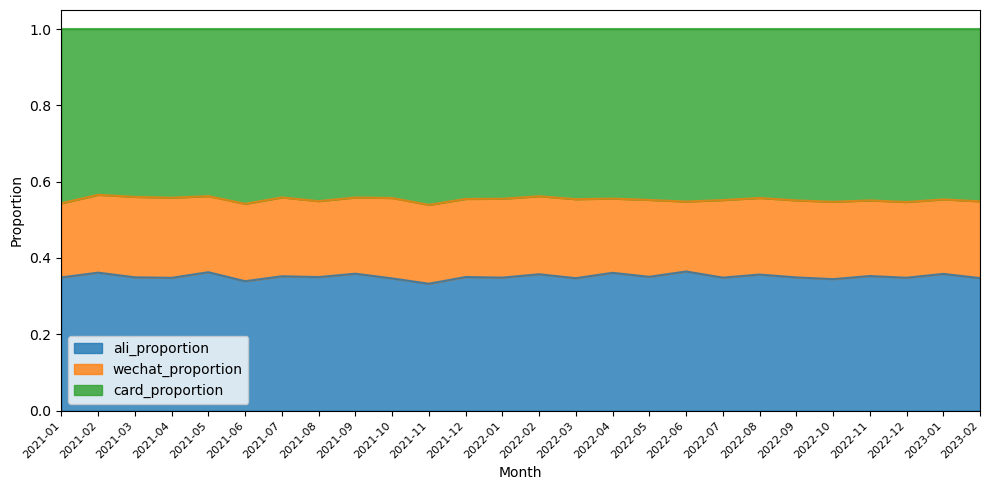

In [40]:
df_payment.index = pd.to_datetime(df_payment.index, format="%Y-%m")

ax = df_payment[['ali_proportion', 'wechat_proportion', 'card_proportion']].plot(
    kind='area',        
    stacked=True,      
    figsize=(10, 5),
    alpha=0.8        
)

ax.set_xticks(df_payment.index)  
ax.set_xticklabels(df_payment.index.strftime('%Y-%m'), rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Proportion')
ax.set_xlabel('Month')

plt.tight_layout()
plt.show()

可以看到，每月各支付方式的人数当月占比保持稳定

<a id="section8"></a>

### 节假日分析

现在我们考虑是否有潜在的外部因素--当月/季度含有的大型节假日--影响了GMV表现和规律的出现

目前我们看到的规律：
- 第二，三与四季度是增长关键季度
- 第一季度中第二月规律性乏力，后第三月回暖；
- 每年7月与10月为全年顶峰两月，第二月为全年低谷；5月为第二季度关键月，同样的第三季度为第7月，第四季度为第10月

问题：
- 22年Q4业务有一定问题
- 22年Q4同比差主要因为10月与11月同比差
- 同比看22年2，7，10与11月乏力明显，3，6，9与12月表现相对较好，其中三月环比与同比均可观

在每一季度中，我们选取一个代表性的固定大型节日活动:
- 第一季度：三八妇女节
- 第二季度：6.18 购物节
- 第三季度：8.18 购物节
- 第四季度：双11购物节

三八妇女节：

我们考虑时间段：01/03 - 08/03，来包含节前预热以及节后余热，同时选取2月1号至8号相同长度时间段为基准

In [41]:
start_date, end_date = '2021-03-01', '2021-03-08'
women_day_21 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]
start_date, end_date = '2021-02-01', '2021-02-08'
feb_day_21 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]

day_women_21 = women_day_21.groupby('day').agg({
    'price': 'sum'
})

day_feb_21 = feb_day_21.groupby('day').agg({
    'price': 'sum'
})

In [42]:
start_date, end_date = '2022-03-01', '2022-03-08'
women_day_22 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]
start_date, end_date = '2022-02-01', '2022-02-08'
feb_day_22 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]

day_women_22 = women_day_22.groupby('day').agg({
    'price': 'sum'
})

day_feb_22 = feb_day_22.groupby('day').agg({
    'price': 'sum'
})

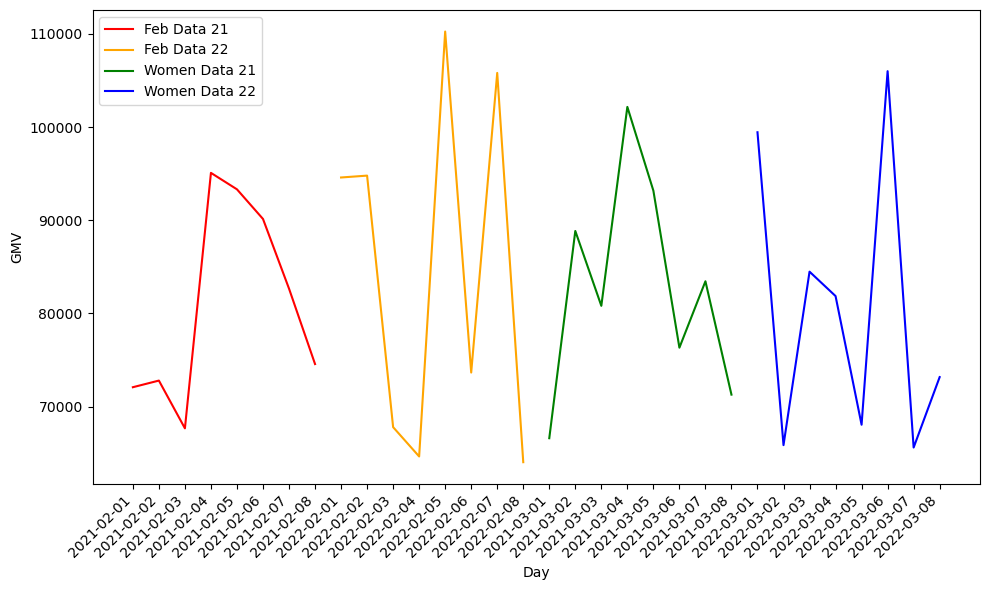

In [43]:
plt.figure(figsize=(10, 6)) 
plt.plot(day_feb_21.index, day_feb_21.values, label='Feb Data 21', color='red')
plt.plot(day_feb_22.index, day_feb_22.values, label='Feb Data 22', color='orange')
plt.plot(day_women_21.index, day_women_21.values, label='Women Data 21', color='green')
plt.plot(day_women_22.index, day_women_22.values, label='Women Data 22', color='blue')
plt.xlabel('Day')
plt.ylabel('GMV')
plt.xticks(rotation=45, ha='right')
plt.legend() 
plt.tight_layout()
plt.show()

In [44]:
print('21年三八妇女节期间GMV：', day_women_21.sum().values[0], '\n21年2月同期间GMV：', day_feb_21.sum().values[0])

21年三八妇女节期间GMV： 662665.6599999999 
21年2月同期间GMV： 648303.78


In [45]:
print('21年三八妇女节期间总单数:', 
      women_day_21.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0],
     '\n21年2月期间总单数:',
     feb_day_21.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0])

21年三八妇女节期间总单数: 976 
21年2月期间总单数: 954


In [46]:
print('22年三八妇女节期间GMV：', day_women_22.sum().values[0], '\n22年2月同期间GMV：', day_feb_22.sum().values[0])

22年三八妇女节期间GMV： 644478.09 
22年2月同期间GMV： 675572.35


In [47]:
print('22年三八妇女节期间总单数:', 
      women_day_22.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0],
     '\n22年2月期间总单数:',
     feb_day_22.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0])

22年三八妇女节期间总单数: 1024 
22年2月期间总单数: 964


618购物节：

我们考虑时间段：01/06 - 18/06，来包含节前预热以及节后余热，同时选取5月1号至18号相同长度时间段为基准

In [48]:
start_date, end_date = '2021-06-01', '2021-06-18'
shop_618_21 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]
start_date, end_date = '2021-05-01', '2021-05-18'
may_day_21 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]

day_shop_618_21 = shop_618_21.groupby('day').agg({
    'price': 'sum'
})

day_may_21 = may_day_21.groupby('day').agg({
    'price': 'sum'
})

In [49]:
start_date, end_date = '2022-06-01', '2022-06-18'
shop_618_22 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]
start_date, end_date = '2022-05-01', '2022-05-18'
may_day_22 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]

day_shop_618_22 = shop_618_22.groupby('day').agg({
    'price': 'sum'
})

day_may_22 = may_day_22.groupby('day').agg({
    'price': 'sum'
})

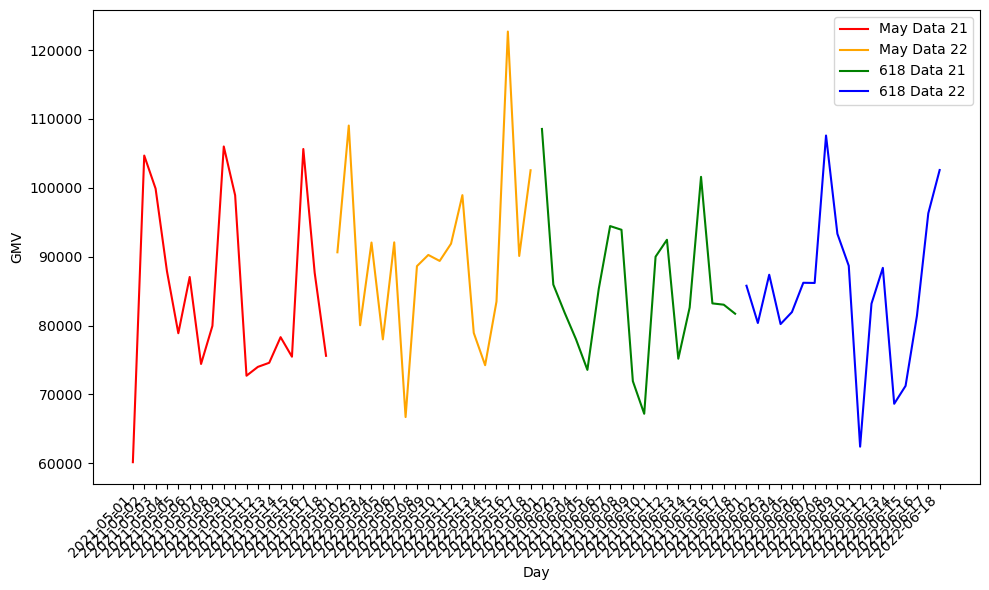

In [50]:
plt.figure(figsize=(10, 6)) 
plt.plot(day_may_21.index, day_may_21.values, label='May Data 21', color='red')
plt.plot(day_may_22.index, day_may_22.values, label='May Data 22', color='orange')
plt.plot(day_shop_618_21.index, day_shop_618_21.values, label='618 Data 21', color='green')
plt.plot(day_shop_618_22.index, day_shop_618_22.values, label='618 Data 22', color='blue')
plt.xlabel('Day')
plt.ylabel('GMV')
plt.xticks(rotation=45, ha='right')
plt.legend() 
plt.tight_layout()
plt.show()

In [51]:
print('21年618期间GMV：', day_shop_618_21.sum().values[0], '\n21年5月同期间GMV：', day_may_21.sum().values[0])

21年618期间GMV： 1530469.06 
21年5月同期间GMV： 1521768.2599999998


In [52]:
print('21年618期间总单数:', 
      shop_618_21.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0],
     '\n21年5月同期间总单数:',
     may_day_21.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0])

21年618期间总单数: 2239 
21年5月同期间总单数: 2241


In [53]:
print('22年618期间GMV：', day_shop_618_22.sum().values[0], '\n22年5月同期间GMV：', day_may_22.sum().values[0])

22年618期间GMV： 1531772.8299999998 
22年5月同期间GMV： 1619621.5500000003


In [54]:
print('22年618期间总单数:', 
      shop_618_22.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0],
     '\n22年5月期间总单数:',
     may_day_22.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0])

22年618期间总单数: 2275 
22年5月期间总单数: 2237


818购物节：

我们考虑时间段：01/08 - 18/08，来包含节前预热以及节后余热，同时选取7月13号至31号相同长度时间段为基准

In [55]:
start_date, end_date = '2021-08-01', '2021-08-18'
shop_818_21 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]
start_date, end_date = '2021-07-13', '2021-07-31'
july_day_21 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]

day_shop_818_21 = shop_818_21.groupby('day').agg({
    'price': 'sum'
})

day_july_21 = july_day_21.groupby('day').agg({
    'price': 'sum'
})

In [56]:
start_date, end_date = '2022-08-01', '2022-08-18'
shop_818_22 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]
start_date, end_date = '2022-07-13', '2022-07-31'
july_day_22 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]

day_shop_818_22 = shop_818_22.groupby('day').agg({
    'price': 'sum'
})

day_july_22 = july_day_22.groupby('day').agg({
    'price': 'sum'
})

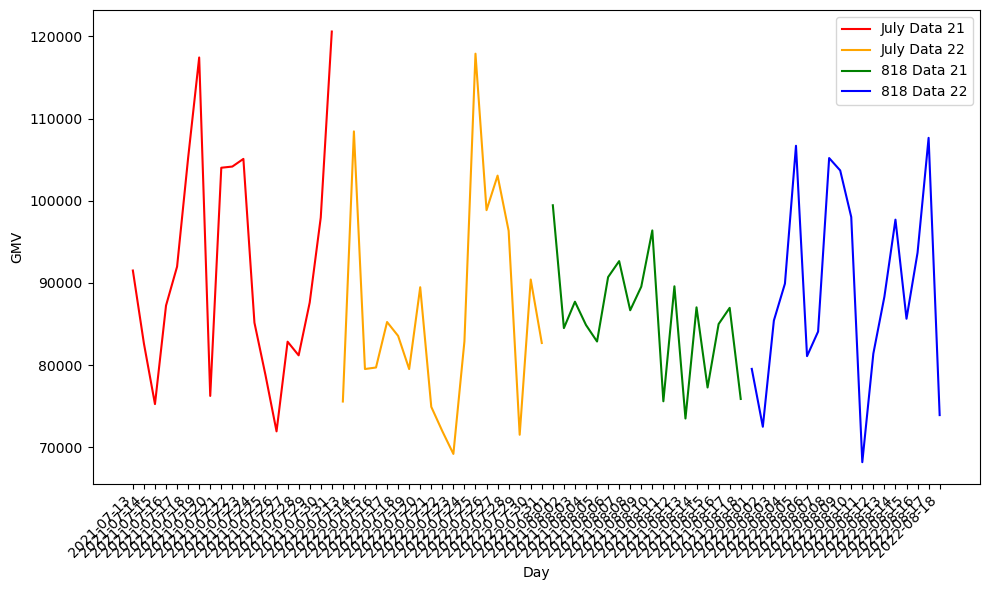

In [57]:
plt.figure(figsize=(10, 6)) 
plt.plot(day_july_21.index, day_july_21.values, label='July Data 21', color='red')
plt.plot(day_july_22.index, day_july_22.values, label='July Data 22', color='orange')
plt.plot(day_shop_818_21.index, day_shop_818_21.values, label='818 Data 21', color='green')
plt.plot(day_shop_818_22.index, day_shop_818_22.values, label='818 Data 22', color='blue')
plt.xlabel('Day')
plt.ylabel('GMV')
plt.xticks(rotation=45, ha='right')
plt.legend() 
plt.tight_layout()
plt.show()

In [58]:
print('21年818期间GMV：', day_shop_818_21.sum().values[0], '\n21年7月同期间GMV：', day_july_21.sum().values[0])

21年818期间GMV： 1546250.16 
21年7月同期间GMV： 1746846.3


In [59]:
print('21年818期间总单数:', 
      shop_818_21.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0],
     '\n21年7月同期间总单数:',
     july_day_21.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0])

21年818期间总单数: 2150 
21年7月同期间总单数: 2476


In [60]:
print('22年818期间GMV：', day_shop_818_22.sum().values[0], '\n22年7月同期间GMV：', day_july_22.sum().values[0])

22年818期间GMV： 1602666.13 
22年7月同期间GMV： 1640800.7000000002


In [61]:
print('22年818期间总单数:', 
      shop_818_22.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0],
     '\n22年7月同期间总单数:',
     july_day_22.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0])

22年818期间总单数: 2302 
22年7月同期间总单数: 2390


双11购物节：

我们考虑时间段：31/10 - 11/11，来包含节前预热以及节后余热，同时选取10月1号至12号相同长度时间段为基准

In [62]:
start_date, end_date = '2021-10-31', '2021-11-11'
shop_11_21 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]
start_date, end_date = '2021-10-01', '2021-10-12'
oct_day_21 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]

day_shop_11_21 = shop_11_21.groupby('day').agg({
    'price': 'sum'
})

day_oct_21 = oct_day_21.groupby('day').agg({
    'price': 'sum'
})

In [63]:
start_date, end_date = '2022-10-31', '2022-11-11'
shop_11_22 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]
start_date, end_date = '2022-10-01', '2022-10-12'
oct_day_22 = data[(data['invoice_date'] >= start_date) & (data['invoice_date'] <= end_date)]

day_shop_11_22 = shop_11_22.groupby('day').agg({
    'price': 'sum'
})

day_oct_22 = oct_day_22.groupby('day').agg({
    'price': 'sum'
})

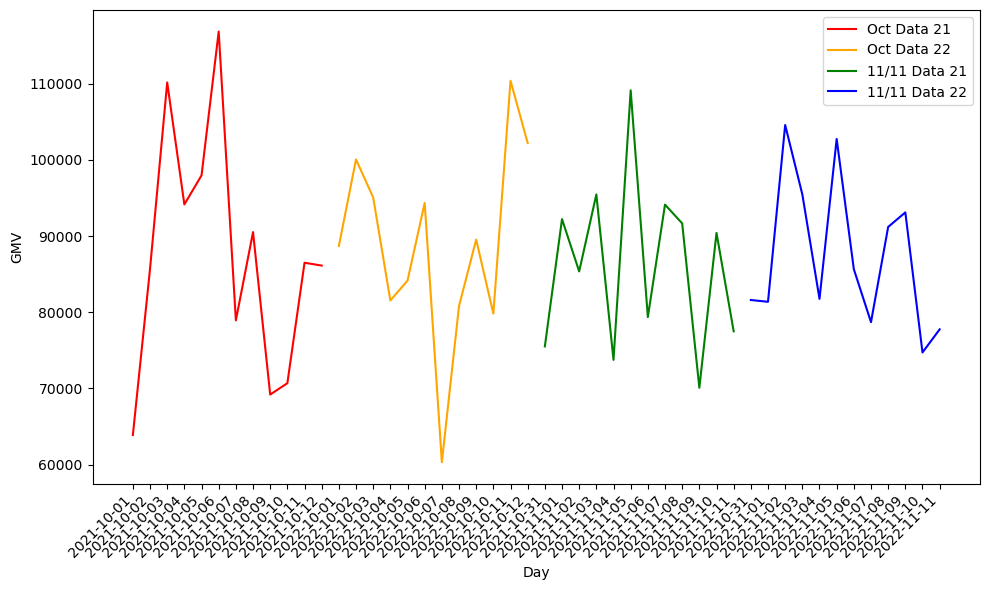

In [64]:
plt.figure(figsize=(10, 6)) 
plt.plot(day_oct_21.index, day_oct_21.values, label='Oct Data 21', color='red')
plt.plot(day_oct_22.index, day_oct_22.values, label='Oct Data 22', color='orange')
plt.plot(day_shop_11_21.index, day_shop_11_21.values, label='11/11 Data 21', color='green')
plt.plot(day_shop_11_22.index, day_shop_11_22.values, label='11/11 Data 22', color='blue')
plt.xlabel('Day')
plt.ylabel('GMV')
plt.xticks(rotation=45, ha='right')
plt.legend() 
plt.tight_layout()
plt.show()

In [65]:
print('21年双11期间GMV：', day_shop_11_21.sum().values[0], '\n21年10月同期间GMV：', day_oct_21.sum().values[0])

21年双11期间GMV： 1034569.8099999998 
21年10月同期间GMV： 1050649.85


In [66]:
print('21年双11期间总单数:', 
      shop_11_21.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0],
     '\n21年10月同期间总单数:',
     oct_day_21.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0])

21年双11期间总单数: 1519 
21年10月同期间总单数: 1526


In [67]:
print('22年双11期间GMV：', day_shop_11_22.sum().values[0], '\n22年10月同期间GMV：', day_oct_22.sum().values[0])

22年双11期间GMV： 1048636.09 
22年10月同期间GMV： 1066922.33


In [68]:
print('22年双11期间总单数:', 
      shop_11_22.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0],
     '\n22年10月同期间总单数:',
     oct_day_22.groupby('day').agg({
    'customer_id': 'nunique'
}).sum().values[0])

22年双11期间总单数: 1554 
22年10月同期间总单数: 1489


结合上文所有的每季度的典型节假日/购物节活动，我们发现活动期间总单数，GMV与平日相比持平甚至减少，且有节日临近高峰时及高峰当日GMV异常低，与我们的常识想违背，我们推测也许是此平台不参与传统的电商活动

根据我们进行的时间维度分析，此平台月度/季度GMV每有波动是因为三大核心品类出现问题，当三大品类整体降幅大于增幅时，导致平台总GMV呈下降趋势，反之上涨
因此想稳定总GMV并想使其上涨，三大品类是重点维护对象

根据历史数据观察到的三大品类随时间变化的规律，我们可结合观测到的规律，在未来月/季对历史相同期间呈上涨的品类着重发力，来提升当月/季GMV表现。例如：衣物品类在每年7月固定顶峰，我们则可制定针对衣物品类的爆量活动；4月-7月为鞋类增长期，我们可以持续投入宣发鞋类商品

下面我们进行RFM分析

## RFM 分析

In [69]:
snapshot_date = data['invoice_date'].max() + pd.Timedelta(days=1)
rfm = data.groupby('customer_id').agg({
    'invoice_date': lambda x: (snapshot_date - x.max()).days,
    'invoice_no': 'nunique',
    'price': 'sum'
}).rename(columns={
    'invoice_date': 'Recency',
    'invoice_no': 'Frequency',
    'price': 'Monetary'
})

In [70]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=range(5,0,-1))
rfm['F_score'] = [1] * rfm.shape[0]
rfm['M_score'] = pd.qcut(rfm['Monetary'],5, labels=range(1,6))

因为每个客户的Frequency score都是1，因此我们只根据Rcency与Monetary score划分客户

考虑到此平台历史数据中，每个客户都只进行一次购物，无留存，我们优先考虑最近购物的客户，其次再考虑总消费金额高的客户

我们一共划分9类客户，各类条件如下表所示

| 客户种类         | 条件                                                                 |
| -------------- | -------------------------------------------------------------------- |
| 高价值客户     | R score>= 4 & M score>= 4                                            |
| 活跃忠诚客户    | R score>= 4 & (2 <= M score<= 3)                                            |
| 新客低价值         | R score>= 4 & M score< 2                                              |
| 高消费客户            | (2 <= R score<= 3) & M score>= 4                                                          |
| 潜力客户       | (2 <= R score<= 3) & (2 <= M score<= 3)                        |
| 预流失客户       | (2 <= R score<= 3) &  M score< 2                                                               |
| 濒流失客户          | R score< 2 & M score>= 4                                         |
| 需维护客户 | R score< 2 & (2 <= M score<= 3)                       |
| 流失客户   | R score< 2 & M score< 2                       |

In [71]:
def rfm_3x3(r, m):
    if r >= 4:
        r_cat = 'H'   # High
    elif r >= 2:
        r_cat = 'M'   # Medium
    else:
        r_cat = 'L'   # Low

    if m >= 4:
        m_cat = 'H'   # High
    elif m >= 2:
        m_cat = 'M'   # Medium
    else:
        m_cat = 'L'   # Low

    if r_cat == 'H' and m_cat == 'H':
        return '高价值客户'
    if r_cat == 'H' and m_cat == 'M':
        return '活跃忠诚客户'
    if r_cat == 'H' and m_cat == 'L':
        return '新客低价值'
    if r_cat == 'M' and m_cat == 'H':
        return '高消费客户'
    if r_cat == 'M' and m_cat == 'M':
        return '潜力客户'
    if r_cat == 'M' and m_cat == 'L':
        return '预流失客户'
    if r_cat == 'L' and m_cat == 'H':
        return '濒流失客户'
    if r_cat == 'L' and m_cat == 'M':
        return '需维护客户'
    if r_cat == 'L' and m_cat == 'L':
        return '流失客户'

    return 'Undefined'

In [72]:
rfm['customer_category'] = rfm.apply(
    lambda row: rfm_3x3(row['R_score'], row['M_score']), axis=1
)

In [73]:
rfm['customer_category'].value_counts()

customer_category
活跃忠诚客户    16876
潜力客户      16711
高消费客户     14306
高价值客户     14186
新客低价值      8763
预流失客户      8743
需维护客户      8290
濒流失客户      7234
流失客户       4348
Name: count, dtype: int64

结合各类用户分布图与平均RFM score热力图来看，平台排名前四的客户分别为活跃忠诚客户、 潜力客户、高消费客户与高价值客户，除开潜力客户，其他三类客户的平均RM score中至少有一个为4.5，且这三类用户占比接近50%，应为平台重点维护对象

平台首先应尝试对所有类别用户进行召回，但重点关注这四类核心用户，提高平台对于他们的曝光频率，制定优惠活动策略刺激再次下单。在能够召回客户的前提下，平台可再对于平均M score低的活跃忠诚客户与潜力客户制定特定计划提升消费，同时核心维护高价值客户

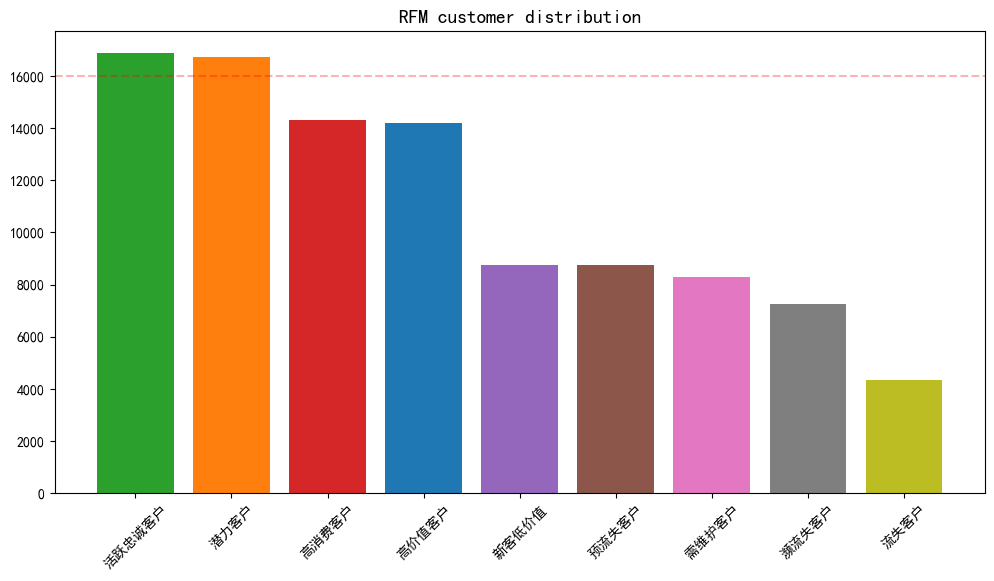

In [74]:
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'WenQuanYi Micro Hei']  
mpl.rcParams['axes.unicode_minus'] = False 

plt.figure(figsize=(12,6))
plt.bar(list(rfm['customer_category'].value_counts().index), list(rfm['customer_category'].value_counts().values), color=['#2ca02c','#ff7f0e','#d62728','#1f77b4','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22'])
plt.axhline(y=16000, color='r', linestyle='--', alpha=0.3) 
plt.title("RFM customer distribution", fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [75]:
print('活跃忠诚客户, 高消费客户, 高价值客户总占比：', 
     (rfm['customer_category'].isin(['活跃忠诚客户', '高消费客户', '高价值客户']).sum() * 100/ rfm.shape[0]).round(2),'%'
     )

活跃忠诚客户, 高消费客户, 高价值客户总占比： 45.62 %


In [76]:
sub = rfm[['customer_category', 'R_score', 'F_score', 'M_score']]
sub['R_score'] = sub.loc[:,'R_score'].astype(int)
sub['F_score'] = sub.loc[:,'F_score'].astype(int)
sub['M_score'] = sub.loc[:,'M_score'].astype(int)

rfm_grouped = sub.groupby('customer_category').mean()

order = ['高价值客户', '活跃忠诚客户', '新客低价值', '高消费客户', '潜力客户',
    '预流失客户', '濒流失客户', '需维护客户', '流失客户']
rfm_grouped = rfm_grouped.reindex(order)

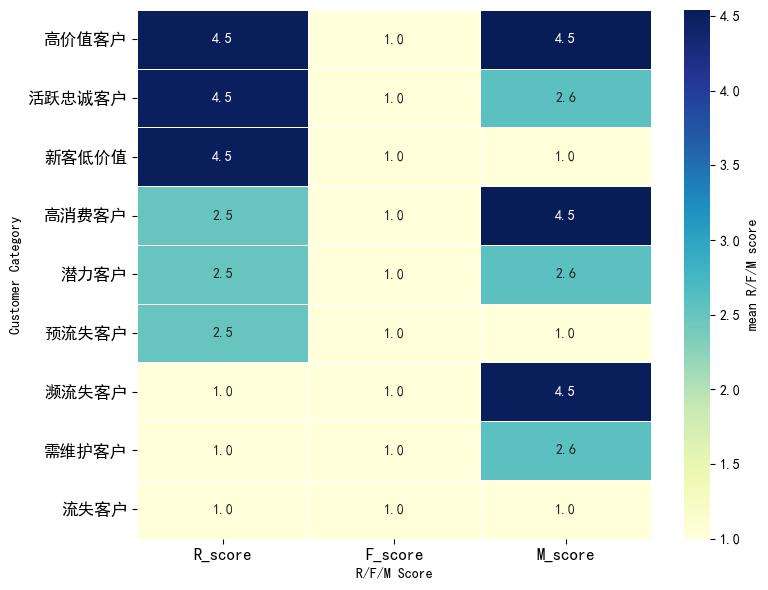

In [77]:
plt.figure(figsize=(8, 6))  
sns.heatmap(
    rfm_grouped,          
    annot=True,            
    fmt=".1f",             
    cmap="YlGnBu",         
    cbar_kws={"label": "mean R/F/M score"},  
    linewidths=0.5         
)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.xlabel("R/F/M Score")
plt.ylabel("Customer Category")
plt.tight_layout()
plt.show()

我们最后再从不同维度拆解，探寻这四类用户情况是否与整体用户情况有不同的地方

In [78]:
four_customer = data[data['customer_id'].isin(rfm[rfm['customer_category'].isin(['活跃忠诚客户', '潜力客户', '高消费客户', '高价值客户'])].index)]

In [79]:
gender_value = [sum(four_customer["gender"] == 'Female'), sum(four_customer["gender"] == 'Male')]
gender = ['Female', 'Male']
print('女性占比:', round(gender_value[0] * 100/ sum(gender_value),2),'%',
     '\n男性占比:', round(gender_value[1] * 100/ sum(gender_value),2),'%')

女性占比: 59.83 % 
男性占比: 40.17 %


In [80]:
age_value = [sum(four_customer["age_cat"] == 1), sum(four_customer["age_cat"] == 2),sum(four_customer["age_cat"] == 3),
             sum(four_customer["age_cat"] == 4), sum(four_customer["age_cat"] == 5)]
age = sorted(four_customer["age_cat"].values.unique().astype(int))

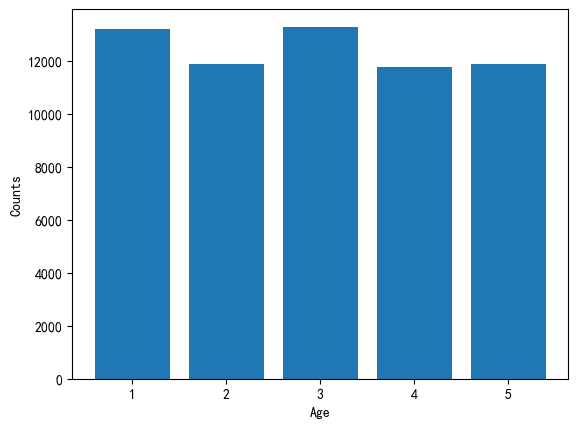

In [81]:
plt.figure()
plt.bar(age, age_value)
plt.xlabel('Age')
plt.ylabel('Counts')
plt.show()

In [82]:
four_customer.groupby('age_cat')['price'].sum() / sum(four_customer['price'])

age_cat
1    0.210514
2    0.190170
3    0.217923
4    0.188564
5    0.192829
Name: price, dtype: float64

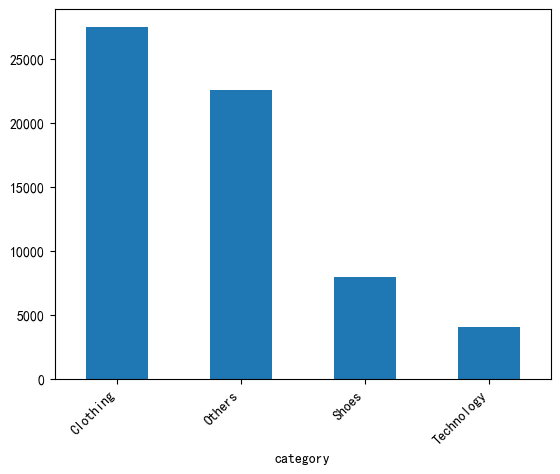

In [83]:
plt.figure()
four_customer['category'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=45, ha='right')
plt.show()

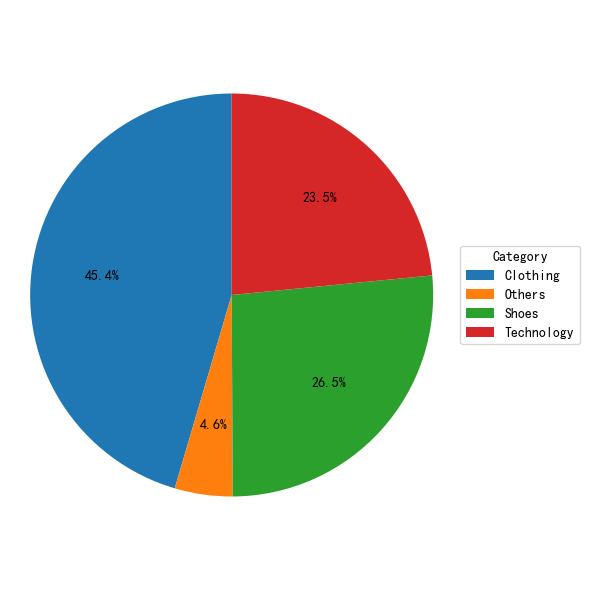

In [84]:
pct = four_customer.groupby('category')['price'].sum() / sum(four_customer['price'])
pct = pct.reset_index(name='pct')
pct = pct.set_index('category')

fig, ax = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax.pie(
    pct['pct'],
    labels = None,
    autopct = '%1.1f%%',
    startangle=90,
    pctdistance=0.65,
    textprops={'fontsize': 10}
)
ax.legend(
    wedges,
    pct.index,
    title="Category",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)

#ax.set_title('Price Share by Category')
ax.axis('equal')
plt.tight_layout()
plt.show()

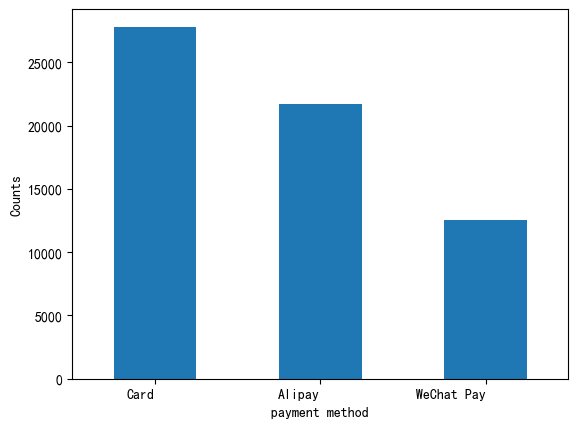

In [85]:
plt.figure()
four_customer['payment_method'].value_counts().plot(kind = 'bar')
plt.xticks(rotation=0, ha='right')
plt.xlabel('payment method')
plt.ylabel('Counts')
plt.show()

In [86]:
print('GMV proportion:')
print(four_customer.groupby('payment_method')['price'].sum() / sum(four_customer['price']))

GMV proportion:
payment_method
Alipay        0.349620
Card          0.447927
WeChat Pay    0.202453
Name: price, dtype: float64


In [87]:
four_customer.groupby('payment_method').agg({
    'price': 'mean'
}).rename(columns = {'price': 'average price'})

,average price
payment_method,
Alipay,877.807839
Card,878.237069
WeChat Pay,878.846538


我们发现这四类用户情况符合整体用户，无特殊的规律或分布出现

<a id="section5"></a>

# 5. 结论与建议

在本次分析中，我们首先从宏观层面对平台整体数据进行了探索，基于用户性别、年龄、支付方式和商品品类等维度，梳理了平台自2021年至2023年初的用户结构与销售情况。

随后，我们引入时间维度，先后进行了季度与月度的分析，结果显示，平台在不同季节和月份中既有表现突出的周期，也存在销售乏力的阶段。同时，从品类角度观察，发现衣物、鞋类及科技产品构成平台的核心销售品类，对整体营收起到决定性作用，是未来重点运营与优化的对象。

最后我们基于RFM模型对用户进行价值细分。由于数据的特殊性，我们采用了RM评分机制将用户划分为9个群组，其中我们识别了四类平台的主力用户。针对这些主力群体中表现相对较弱的评分维度，提出了相应的提升建议。但在执行提升策略前，首先需确保这些用户在平台的活跃度与消费频率达到一定水平。

同时我们根据上文分析模拟制作了可用于未来监控平台实时业务的销售看板：https://public.tableau.com/app/profile/alan.fu7611/viz/fyz_hn9x/1